In [1]:
import pandas as pd 

df = pd.read_csv("nearest-earth-objects(1910-2024).csv")

df.head(10)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
5,3656926,(2014 BT8),25.00,0.026580,0.059435,Earth,47477.649832,4.290521e+07,False
6,3421513,(2008 OX1),21.50,0.133216,0.297879,Earth,57853.295346,2.727908e+07,True
7,3541504,(2010 OF101),19.75,0.298233,0.666868,Earth,46972.486794,6.997593e+07,False
8,3836942,(2018 YH),21.70,0.121494,0.271669,Earth,37424.548382,5.657727e+06,True
9,3892166,(2019 UP13),23.45,0.054269,0.121350,Earth,38524.867869,6.166118e+07,False


In [2]:
# Discard unuseful columns.
df.drop(columns=["neo_id" , "name" , "orbiting_body"] , inplace=True)

In [3]:
#Data loss after discard duplicated rows.
print(1-len(df.drop_duplicates())/len(df))
df.drop_duplicates(inplace=True)

1.4784195104033948e-05


In [4]:
#Data loss after discard NaN values.
print(1-len(df.dropna()) / len(df))
df.dropna(inplace=True)

8.279271660649457e-05


In [5]:
#Encoding target column
from sklearn.preprocessing import OrdinalEncoder

df.is_hazardous = OrdinalEncoder().fit_transform(df[["is_hazardous"]])
df.head(10)

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,0.0
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,1.0
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,0.0
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,0.0
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,0.0
5,25.00,0.026580,0.059435,47477.649832,4.290521e+07,0.0
6,21.50,0.133216,0.297879,57853.295346,2.727908e+07,1.0
7,19.75,0.298233,0.666868,46972.486794,6.997593e+07,0.0
8,21.70,0.121494,0.271669,37424.548382,5.657727e+06,1.0
9,23.45,0.054269,0.121350,38524.867869,6.166118e+07,0.0


In [6]:
df.describe()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
count,338166.000000,338166.000000,338166.000000,338166.000000,3.381660e+05,338166.000000
mean,22.932585,0.157808,0.352869,51059.468158,4.153533e+07,0.127636
std,2.911196,0.313885,0.701869,26399.719888,2.077414e+07,0.333684
min,9.250000,0.000511,0.001143,203.346433,6.745533e+03,0.000000
25%,20.740000,0.025384,0.056760,30710.389675,2.494425e+07,0.000000
50%,22.800000,0.073207,0.163697,47556.423786,4.332699e+07,0.000000
75%,25.100000,0.189041,0.422708,66672.024527,5.933949e+07,0.000000
max,33.580000,37.545248,83.953727,291781.106613,7.479865e+07,1.000000


array([[<Axes: title={'center': 'absolute_magnitude'}>,
        <Axes: title={'center': 'estimated_diameter_min'}>],
       [<Axes: title={'center': 'estimated_diameter_max'}>,
        <Axes: title={'center': 'relative_velocity'}>],
       [<Axes: title={'center': 'miss_distance'}>,
        <Axes: title={'center': 'is_hazardous'}>]], dtype=object)

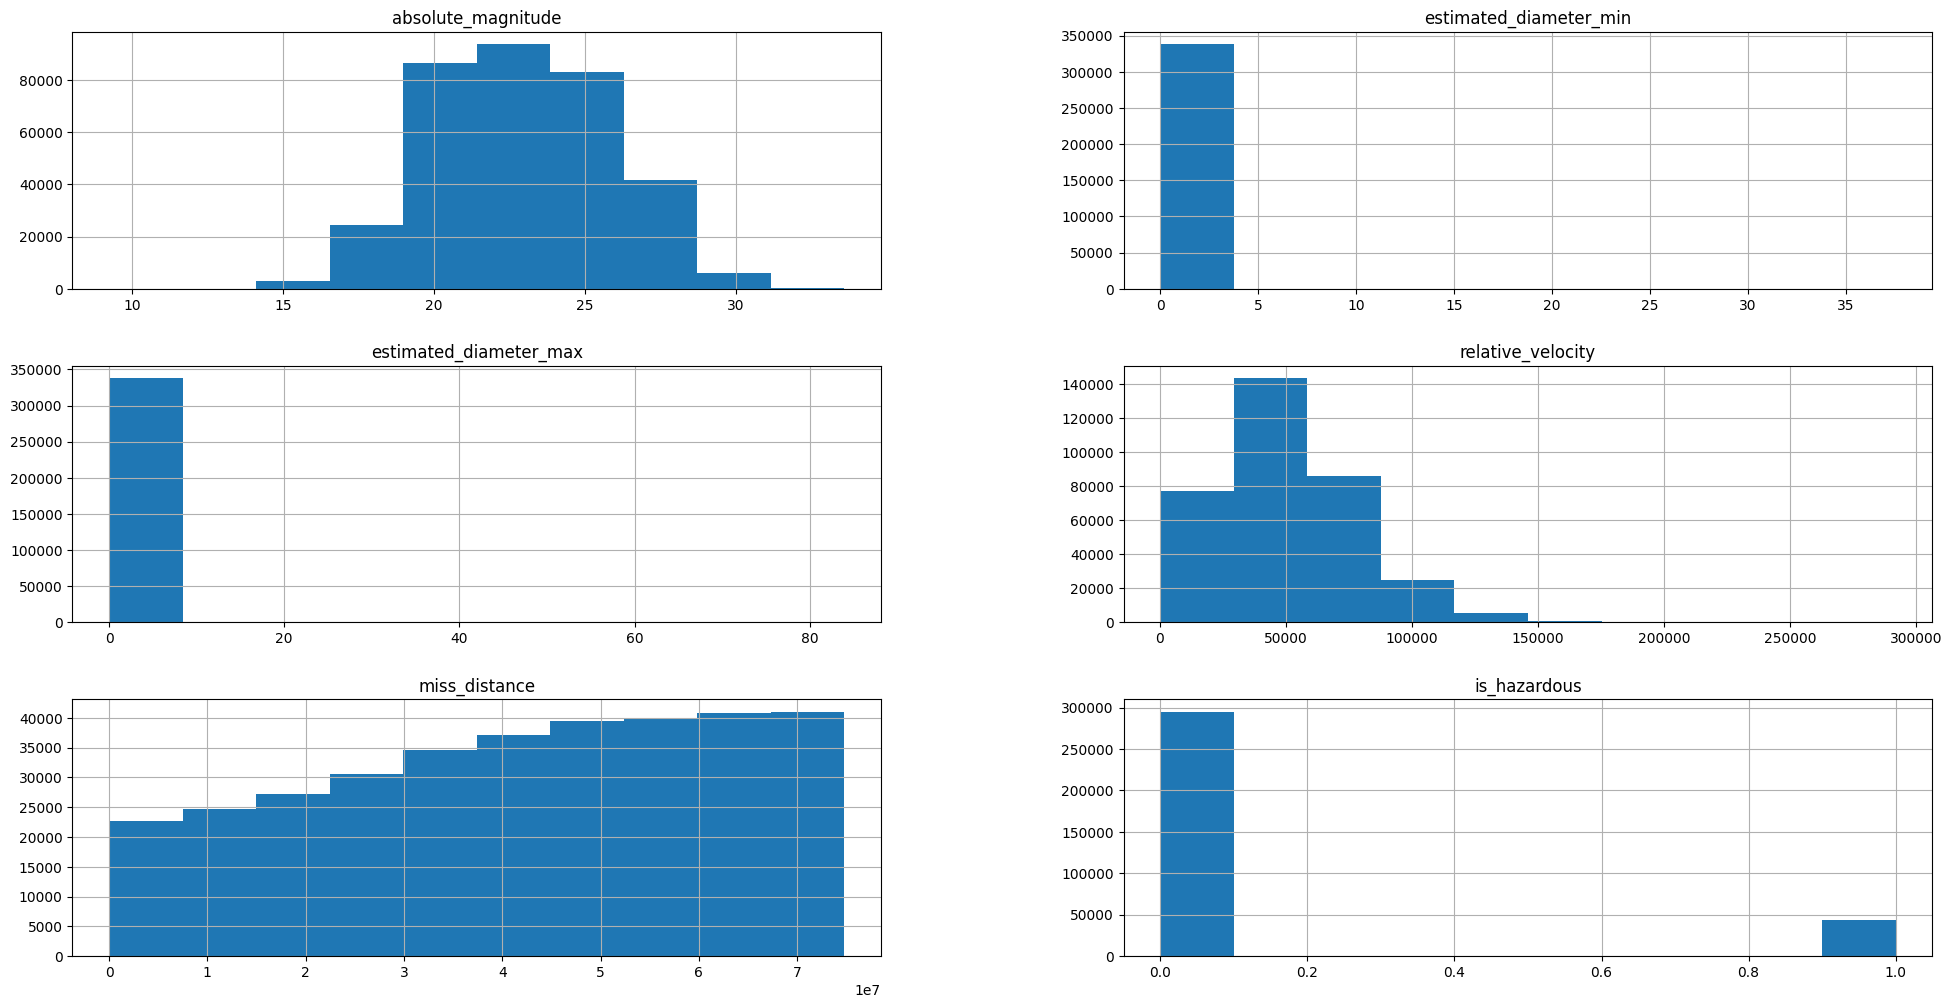

In [7]:
df.hist(figsize=(24,12))

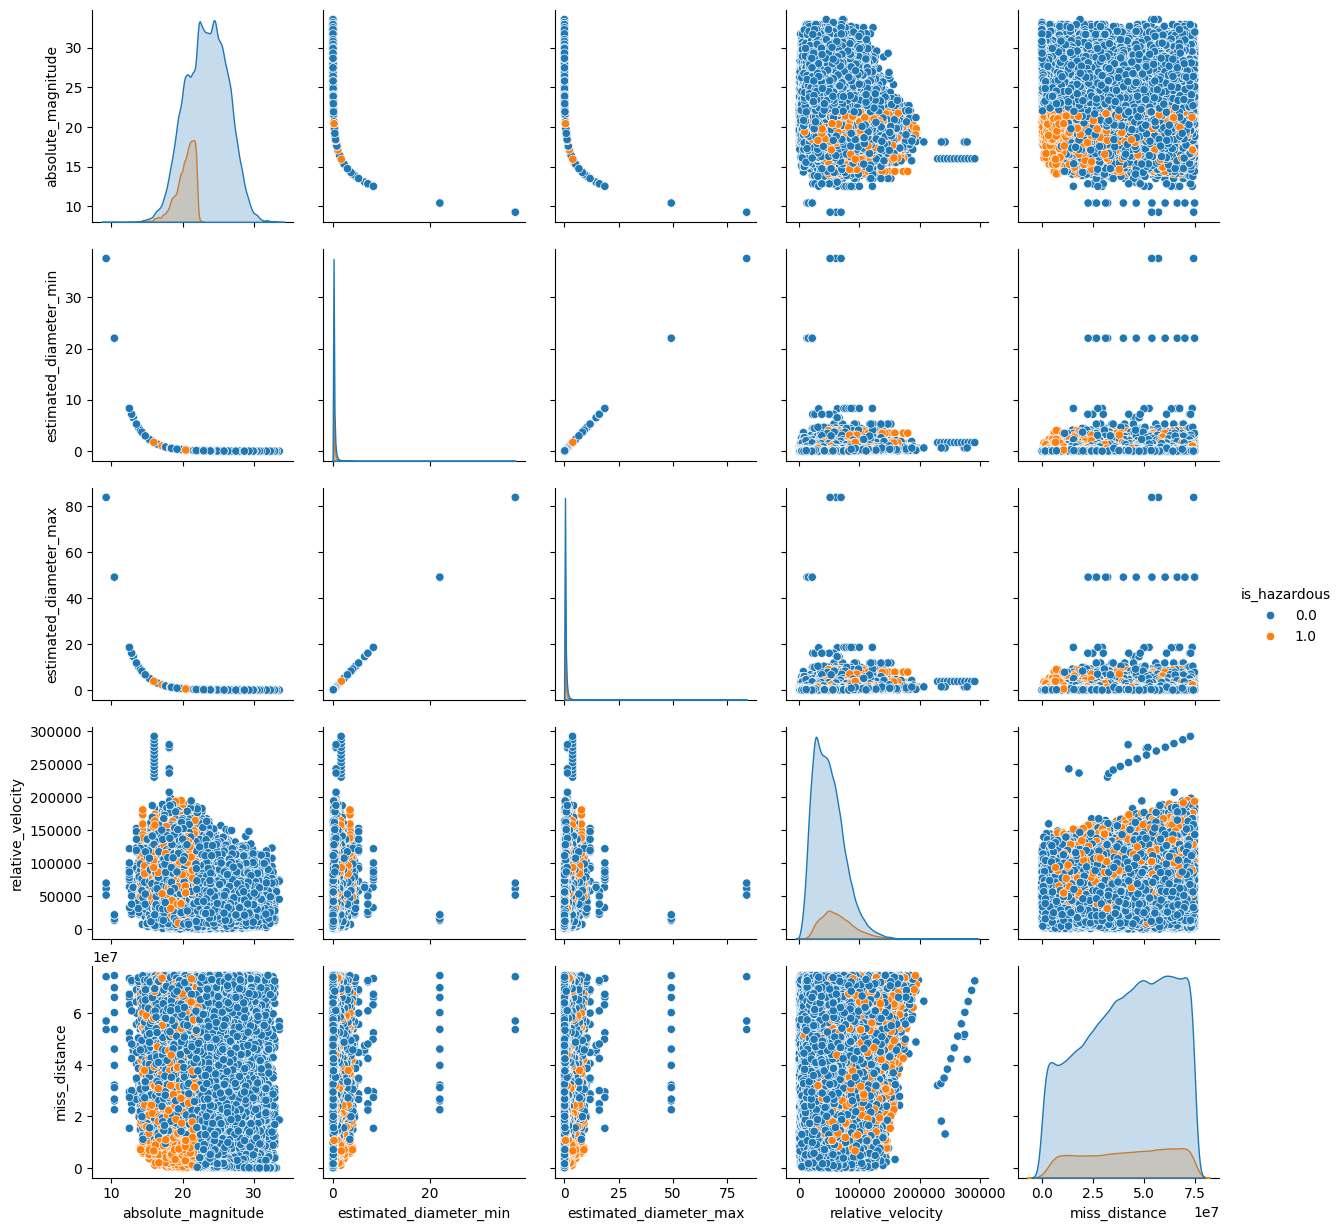

In [8]:
import seaborn as sns

sns.pairplot(df , hue="is_hazardous" )

In [9]:
#Percentage of True values
df.is_hazardous.sum() / len(df.is_hazardous)

0.127635539941922

SEARCH FOR THE BEST MODEL

Our goal is to build a predictive model with high recall. We choose recall over precision given the nature of the problem to solve, the goal is to detetect most cases of potentially hazardous asteroids, even when we
probably get more falses alarms.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer, precision_score, accuracy_score , roc_auc_score

X_train , X_test , y_train , y_test = train_test_split( df.drop(columns=["is_hazardous"]) ,  df.is_hazardous,  test_size=0.2 , random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [11]:
from sklearn.neighbors import KNeighborsClassifier 

clf1 = GridSearchCV(cv=10, estimator = KNeighborsClassifier() , 
                   param_grid={ "n_neighbors" : [2,3,5,10,15,20,100,200,300,1000]} , 
                   scoring = {"recall" : make_scorer(recall_score)} , 
                   refit = "recall" ,
                   n_jobs=-1)



clf1.fit(X_train , y_train)
pred1 = clf1.predict(X_test)

clf1_Scores=[ 
             "clf1",
             recall_score(y_test , pred1),
             roc_auc_score(y_test , pred1),
             precision_score(y_test , pred1),
             accuracy_score(y_test , pred1)
]

print(clf1_Scores)


['clf1', 0.43909774436090226, 0.6903739412611273, 0.5244542691351202, 0.8774137268237868]


In [12]:

from sklearn.ensemble import RandomForestClassifier 

clf2 = GridSearchCV(cv=10, estimator = RandomForestClassifier() , 
                   param_grid= { "ccp_alpha" : [0 , 10 , 20 ,30] } , 
                   scoring = {"recall" : make_scorer(recall_score)} , 
                   refit = "recall" ,
                   n_jobs=-1)


clf2.fit(X_train , y_train)
pred2 = clf2.predict(X_test)

clf2_Scores=[ 
             "clf2",
             recall_score(y_test , pred2),
             roc_auc_score(y_test , pred2),
             precision_score(y_test , pred2),
             accuracy_score(y_test , pred2)
]

print(clf2_Scores)

['clf2', 0.5949103528050896, 0.7807910525828496, 0.7234491489660994, 0.9191530886832067]


In [13]:
from sklearn.svm import SVC

clf3 = GridSearchCV(cv=3, estimator = SVC() , 
                   param_grid={ "gamma" : ["scale"]} , 
                   scoring = {"recall" : make_scorer(recall_score)} , 
                   refit = "recall" ,
                   return_train_score=True,
                   n_jobs=-1)
clf3.fit(X_train , y_train)
pred3 = clf3.predict(X_test)

clf3_Scores=[ 
             "clf3",
             recall_score(y_test , pred3),
             roc_auc_score(y_test , pred3),
             precision_score(y_test , pred3),
             accuracy_score(y_test , pred3)
]

print(clf3_Scores)

['clf3', 0.12168883747831116, 0.5583863333334019, 0.7839046199701938, 0.8834461957003874]


Given that we are working with an unbalanced data set lets try to get better scores upsampling it and then re-train clf2 our best model.

In [14]:

from imblearn.combine import SMOTETomek

smk=SMOTETomek()
X_res,y_res = smk.fit_resample(X_train,y_train)

clf4 = GridSearchCV(cv=10, estimator = RandomForestClassifier() , 
                   param_grid= { "ccp_alpha" : [0 , 10 , 20 ,30] } , 
                   scoring = {"recall" : make_scorer(recall_score)} , 
                   refit = "recall" ,
                   n_jobs=-1)



clf4.fit(X_res , y_res)
pred4 = clf4.predict(X_test)

clf4_Scores=[ 
             "clf4",
             recall_score(y_test , pred4),
             roc_auc_score(y_test , pred4),
             precision_score(y_test , pred4),
             accuracy_score(y_test , pred4)
]

print(clf4_Scores)

['clf4', 0.7086176980913823, 0.8232691636806231, 0.6258684102983245, 0.9086110536120886]


CONSTRUCTION OF VOTING CLASSIFIERS

In [16]:
from sklearn.ensemble import VotingClassifier

voting_clf1 = VotingClassifier(
estimators=[('mod7', clf1), ('mod5', clf2), ('mod4', clf3),('mod2', clf4)],
voting="hard" , n_jobs=-1)

voting_clf1.fit(X_train, y_train)

pred_Voting = voting_clf1.predict(X_test)

voting1_Scores=[ 
             "voting_clf1",
             recall_score(y_test , pred_Voting),
             roc_auc_score(y_test , pred_Voting),
             precision_score(y_test , pred_Voting),
             accuracy_score(y_test , pred_Voting)
]

print(voting1_Scores)


['voting_clf1', 0.35060728744939273, 0.6682769099268697, 0.7852331606217616, 0.9047372623236833]


In [17]:
#Training a new VotingClassifier without clf3 trying to recover recall.

voting_clf2 = VotingClassifier(
estimators=[('mod1', clf1), ('mod2', clf2),('mod4', clf4)],
voting="hard" , n_jobs=-1)

voting_clf2.fit(X_train, y_train)

pred_Voting2 = voting_clf2.predict(X_test)

voting2_Scores=[ 
             "voting_clf2",
             recall_score(y_test , pred_Voting2 ),
             roc_auc_score(y_test , pred_Voting2 ),
             precision_score(y_test , pred_Voting2 ),
             accuracy_score(y_test , pred_Voting2 )
]

print(voting2_Scores)

['voting_clf2', 0.5826489300173511, 0.7754401475935642, 0.7288380842135725, 0.9189460922021468]


SCORES RESUME

In [40]:

scores = pd.DataFrame(data= [clf1_Scores ,clf2_Scores,clf3_Scores,clf4_Scores,voting1_Scores,voting2_Scores] 
                         ,columns=["model" ,"recall" , "roc_auc","precision","accuracy"])
    
scores.sort_values(by=["recall"] , ascending=False) 


,model,recall,roc_auc,precision,accuracy
3,clf4,0.708618,0.823269,0.625868,0.908611
1,clf2,0.594910,0.780791,0.723449,0.919153
5,voting_clf2,0.582649,0.775440,0.728838,0.918946
0,clf1,0.439098,0.690374,0.524454,0.877414
4,voting_clf1,0.350607,0.668277,0.785233,0.904737
2,clf3,0.121689,0.558386,0.783905,0.883446


In [ ]:
#clf4 is the best model so is pickled

import pickle

pickle.dump(clf4 , open("model_clf.pkl" , "wb"))
